In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
from os import environ

!mamba run -n tf_on_gpu pip install pyarrow

In [2]:
tf.test.gpu_device_name()

2022-12-15 16:29:29.906002: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 16:29:29.944830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 16:29:29.956772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 16:29:29.958083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

'/device:GPU:0'

In [3]:
from feather_io import FeatherReader    
data_reader_train =  FeatherReader(environ.get("TRAIN_DATA", "efficiency-train"))
train_dataset = data_reader_train.as_tf_dataset()
data_reader_validation =  FeatherReader(environ.get("VALIDATION_DATA", "efficiency-validation"))
validation_dataset = data_reader_validation.as_tf_dataset()

2022-12-15 16:29:31.303194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 16:29:31.304817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 16:29:31.306089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 16:29:31.308066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 16:29:31.309394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [4]:
X, y = next(iter(train_dataset.batch(1_000_000)))
y.shape

2022-12-15 16:29:31.663052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


TensorShape([855359, 4])

In [5]:
#model_type = 'pure_sequential'
model_type = 'with_residual_layers'

In [6]:
if model_type == 'pure_sequential':
    layers = []
    layers += [tf.keras.layers.Dense(
        128, 
        activation='tanh', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L2(1e-3)) for _ in range(4)]

    model = tf.keras.models.Sequential()
    for layer in layers:
        model.add(layer)
    model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))
    model.build(input_shape = [None, X.shape[1]])
    model.summary()

In [7]:
from pprint import pprint 
if model_type == 'with_residual_layers':
    dense_config = dict(
        units=128,
        activation='tanh', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L2(1e-3),
    )
    input = tf.keras.layers.Input(batch_input_shape=[None]+X.shape[1:])
    x = tf.keras.layers.Dense(**dense_config)(input)

    for i in range(5):
        r = tf.keras.layers.Dense(**dense_config)(x)
        x = tf.keras.layers.Add()([x, r])
    x = tf.keras.layers.Dense(y.shape[1], activation='softmax', kernel_initializer='he_normal')(x)

    model = tf.keras.Model(inputs=[input], outputs=[x])
    pprint (dense_config)
    model.summary()

{'activation': 'tanh',
 'kernel_initializer': 'he_normal',
 'kernel_regularizer': <keras.regularizers.L2 object at 0x7ff1280b7f10>,
 'units': 128}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1664        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
add (Add)                       (None, 128)   

In [8]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

In [9]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

batch_size=100_000

training_data = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_data=next(iter(validation_dataset.batch(batch_size)))

history = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 8s 831ms/step - loss: 17.3523 - val_loss: 6.5787
Epoch 2/50
8/8 [==============================] - 7s 855ms/step - loss: 5.8737 - val_loss: 4.9219
Epoch 3/50
8/8 [==============================] - 6s 740ms/step - loss: 4.6968 - val_loss: 4.5363
Epoch 4/50
8/8 [==============================] - 6s 714ms/step - loss: 4.4079 - val_loss: 4.7486
Epoch 5/50
8/8 [==============================] - 5s 693ms/step - loss: 4.1154 - val_loss: 3.9829
Epoch 6/50
8/8 [==============================] - 5s 692ms/step - loss: 3.7650 - val_loss: 4.0615
Epoch 7/50
8/8 [==============================] - 6s 767ms/step - loss: 3.8169 - val_loss: 3.2910
Epoch 8/50
8/8 [==============================] - 6s 761ms/step - loss: 3.2131 - val_loss: 2.8453
Epoch 9/50
8/8 [==============================] - 6s 731ms/step - loss: 2.9900 - val_loss: 5.6225
Epoch 10/50
8/8 [==============================] - 6s 745ms/step - loss: 3.4874 - val_loss: 2.4627
Epoch 11/50
8/8 [=

In [10]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 7s 830ms/step - loss: 1.7085 - val_loss: 1.0574
Epoch 2/50
8/8 [==============================] - 6s 848ms/step - loss: 1.0380 - val_loss: 1.0186
Epoch 3/50
8/8 [==============================] - 6s 765ms/step - loss: 0.9914 - val_loss: 0.9902
Epoch 4/50
8/8 [==============================] - 6s 749ms/step - loss: 0.9658 - val_loss: 0.9355
Epoch 5/50
8/8 [==============================] - 6s 848ms/step - loss: 0.9434 - val_loss: 0.9185
Epoch 6/50
8/8 [==============================] - 6s 733ms/step - loss: 0.9160 - val_loss: 0.9226
Epoch 7/50
8/8 [==============================] - 6s 796ms/step - loss: 0.8991 - val_loss: 0.8952
Epoch 8/50
8/8 [==============================] - 6s 754ms/step - loss: 0.8899 - val_loss: 0.8770
Epoch 9/50
8/8 [==============================] - 6s 776ms/step - loss: 0.8694 - val_loss: 0.9083
Epoch 10/50
8/8 [==============================] - 6s 773ms/step - loss: 0.8651 - val_loss: 0.8402
Epoch 11/50
8/8 [==

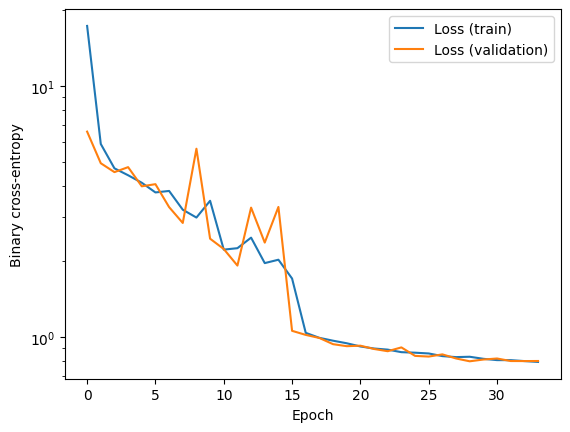

In [11]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('log')
plt.legend()
plt.show()

1.0000352741980998


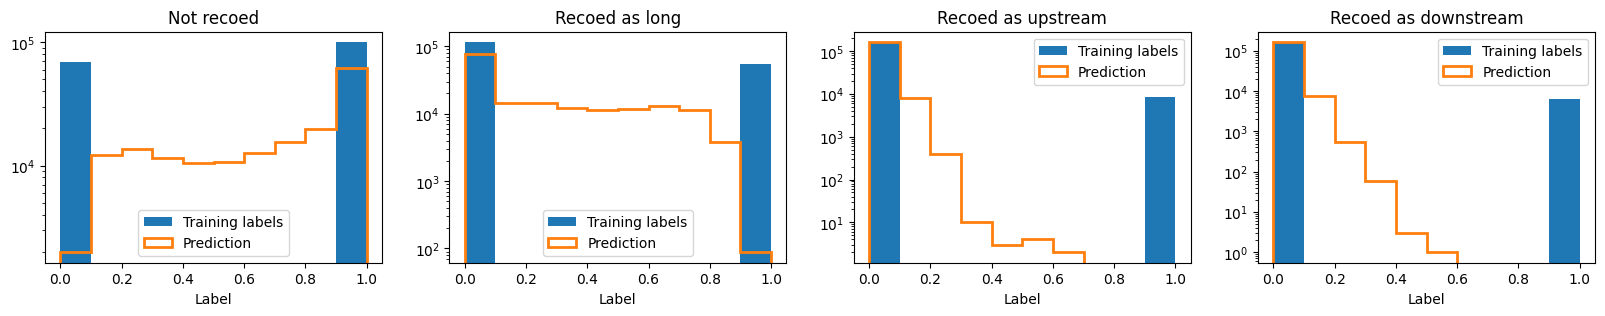

In [12]:
head = data_reader_validation.as_dask_dataframe().head(1_000_000, npartitions=-1)
Xv = head[data_reader_validation.features].values
yv = head[data_reader_validation.labels].values
yv_hat = model.predict(Xv, batch_size=len(Xv))

print (yv.sum(axis=1).mean(axis=0))

n_classes = len(data_reader_validation.labels)
plt.figure(figsize=(5*n_classes, 3))

for iVar, varname in enumerate(data_reader_validation.labels, 0):
    plt.subplot(1, n_classes, iVar+1)
    
    bins = np.linspace(0, 1, 11)
    plt.hist(yv[:, iVar], bins=bins, label="Training labels")
    plt.hist(yv_hat[:, iVar], bins=bins, histtype='step', linewidth=2, label="Prediction")
    plt.title(varname.replace("_", " ").capitalize())
    plt.xlabel("Label")
    plt.legend()
    plt.yscale('log')
plt.show()

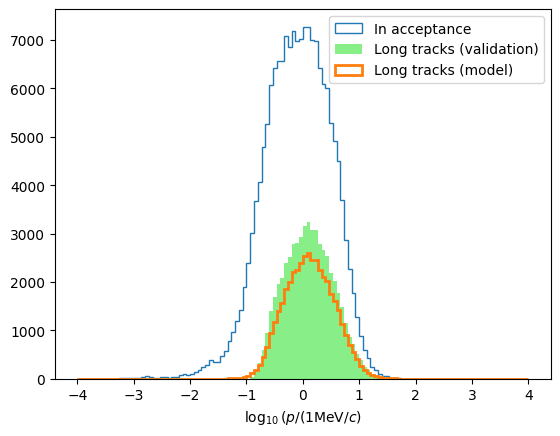

In [13]:
log_p = head['mc_log10_p']
mask_long = head['recoed_as_long'] == 1
w_long = yv_hat[:, data_reader_validation.labels.index('recoed_as_long')]

bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p[mask_long], bins=bins)
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=w_long)

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="In acceptance", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=true_numerator, label="Long tracks (validation)", color='#8e8')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="Long tracks (model)", histtype='step', linewidth=2)

#plt.plot((bins[1:] + bins[:-1])/2, predicted_numerator, label="In acceptance (model)")
#plt.fill_between(
#    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
#    label="In acceptance (validation)",
#    color='#88ee88'
#)
plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend()
plt.show()

In [ ]:
import os
default_output_model = "/workarea/cloud-storage/anderlinil/models/efficiency"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
model.save(output_model)

2022-12-15 16:33:18.474785: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workarea/cloud-storage/anderlinil/models/efficiency/assets


/usr/local/miniconda3/envs/tf_on_gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
